In [32]:
import pandas as pd
import numpy as np
#import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from utils_plot import *

In [33]:
def preprocessing(N, rates, threshold = 2):
    """
    Filter data based on motifs and significance
    """
    #Removal of targets that does not contain any known binding site.
    targetnames_binding_sites = N.index
    targetnames_rates = rates.index
    targetnames = targetnames_rates.intersection(targetnames_binding_sites)
    rates = rates.loc[targetnames]

    # Calculates amplitude over noise of rates around the cell cycle
    mean = rates.groupby('gene').mean().to_numpy()
    sigm = rates.groupby('gene').std().to_numpy()
    ampl = (mean.max(axis=1)-mean.min(axis=1))/2
    zval = ampl/sigm.mean(axis=1)

    # This selects targets with zval > 2 (2 is arbitrary!!!)
    # We filter rates for selected targets
    # N is binding site matrix for selected targets 
    ind = zval > threshold
    rates = mean[ind,:]
    targetnames_filtered = targetnames[ind]

    N_filtered = N.loc[targetnames_filtered].to_numpy()
    N = N_filtered - N_filtered.mean(axis=0,keepdims=True)
    rates = rates - rates.mean(axis=1,keepdims=True) - rates.mean(axis=0,keepdims=True) + rates.mean()
    '''
    plt.hist(zval, bins=50)
    plt.xlabel("z-val")
    plt.ylabel("num_targets")
    plt.show()
    '''
    return rates, N, targetnames_filtered

In [34]:
def fourier_basis(theta, num_harmonics=5):
    """
    Generates a Fourier basis matrix using sine and cosine components
    """
    basis = np.zeros((2*num_harmonics,len(theta)))
    for i in range(num_harmonics):
        basis[2*i,:] = np.cos(2*(i+1)*np.pi*(theta))
        basis[2*i+1,:] = np.sin(2*(i+1)*np.pi*(theta))

    return basis

In [35]:
def fourier_resolution(N, rates, theta_train_idx, num_harmonics=5, lambda1=1, normalization=50):
    """
    Converts a periodic function into Fourier Space, solve a system
    Returns solutions in FS and NS.
    """
    # Matrix with fourier basis (look at the function) F_theta,n 
    F = (fourier_basis(theta, num_harmonics).T)/np.sqrt(normalization) #50 for normalization
    F_train = F[theta_train_idx, :]  # Train basis (10, 80)

    # Transform rates into fourier coefficients rates_hat
    rates_hat = rates @ F_train

    # G is a matrix TFs x TFs and lambda1 is the regularization
    num_BPs = N.shape[1]
    G = (N.T @ N + lambda1 * np.eye(num_BPs))
 
    # Defining the vector b
    b = N.T @ rates_hat

    # Solving the system of linar equations 
    X = np.linalg.solve(G, b)

    # Transforming back from Fourier space (FS) to normal space (NS): X (activites in FS) -> A (activites in NS)
    A = X @ F.T

    return A

In [36]:
def performance_metrics(rates, reconstructed_rates):
    """ Compute Explained variance and Correlation coefficient between rates and reconstructed rates from model """
    EV = 1 - np.var(reconstructed_rates.flatten() - rates.flatten()) / np.var(rates.flatten()) #Explained variance (R2)
    c = np.corrcoef(rates.flatten(), reconstructed_rates.flatten())[0, 1] #Corr coef (Pearson's r)
    return EV, c

### Transcription

In [37]:
#Import files containing the binding sites and the rates for each target.
fileBSM = 'FurierCycleResults/data_binding_site_matrix.txt'
fileAlpha = 'FurierCycleResults/bootstrap_alpha_scrna_100_1_1.csv'
#Defining the process (name, greek letter)
process = ["transcription", "\u03B1"]

In [38]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)
alpha = pd.read_csv(fileAlpha, sep=",",index_col=0)
theta = np.arange(0, 1, 0.01)

In [39]:
# Show the activity of the target (gene, RNA...) along cell cycle.
#plot_target(alpha, process, theta, "Nusap1")

In [40]:
# PREPROCESSING
# Select targets for which we know binding sites in their sequence
tf_names = N.columns
alpha, N, targetnames_filtered = preprocessing(N, alpha, threshold=1)
#Number of retained targets
print("Kept genes :", alpha.shape[0])

Kept genes : 1580


C:\Users\guill\AppData\Local\Temp\ipykernel_12996\4114557101.py:15: RuntimeWarning: invalid value encountered in divide
  zval = ampl/sigm.mean(axis=1)


#### Scikit-learn dataset split

In [61]:
# Define lambda range
lambda_values = np.logspace(-3, 1, 20)  # From 1e-1 to 1e2
results = []

# Split data by theta instead of genes
theta_train_idx, theta_test_idx = train_test_split(
    np.arange(alpha.shape[1]), test_size=0.7, random_state=42
)
#print(theta_train_idx, theta_test_idx)
alpha_train, alpha_test = alpha[:, theta_train_idx], alpha[:, theta_test_idx]
print(alpha_train.shape, alpha_test.shape)

# Grid search over lambda values
for lambda1 in lambda_values:
    # Solve the model with current lambda1
    A = fourier_resolution(N, alpha_train, theta_train_idx, num_harmonics=5, lambda1=lambda1, normalization=50)

    # Reconstructed rates = N*A
    R = N @ A
    R_train, R_test = R[:, theta_train_idx], R[:, theta_test_idx]

    # Compute explained variance & corr coeff
    EV_train, c_train = performance_metrics(alpha_train, R_train)
    EV_test, c_test = performance_metrics(alpha_test, R_test)

    results.append((lambda1, EV_train, c_train, EV_test, c_test))

# Convert results to numpy array for easy sorting
results = np.array(results)

(1580, 30) (1580, 70)


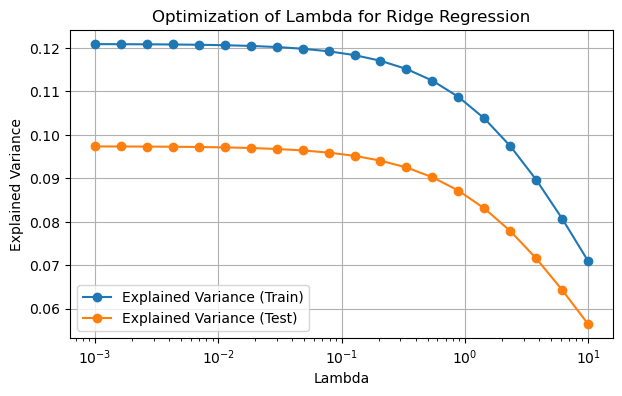

In [62]:
plt.figure(figsize=(7,4))
plt.plot(results[:,0], results[:,1], marker='o', label="Explained Variance (Train)")
plt.plot(results[:,0], results[:,3], marker='o', label="Explained Variance (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Explained Variance")
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()

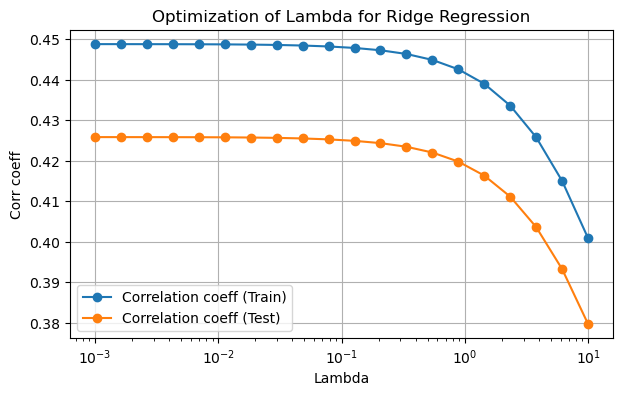

In [63]:
plt.figure(figsize=(7,4))
plt.plot(results[:,0], results[:,2], marker='o', label="Correlation coeff (Train)")
plt.plot(results[:,0], results[:,4], marker='o', label="Correlation coeff (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Corr coeff")
plt.title("Optimization of Lambda for Ridge Regression")
plt.legend()
plt.grid()
plt.show()

In [64]:
%%!

UsageError: %%! is a cell magic, but the cell body is empty.


#### Cross-validation

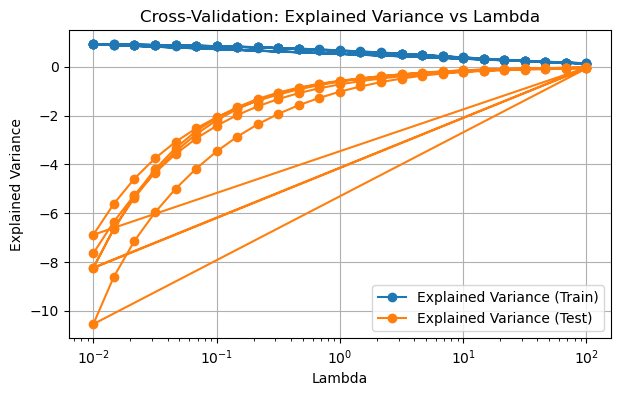

In [ ]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
results_cv = []

for train_index, test_index in kf.split(N):
    N_train, N_test = N[train_index], N[test_index]
    alpha_train, alpha_test = alpha[train_index], alpha[test_index]

    for lambda1 in lambda_values:
        A = fourier_resolution(N_train, alpha_train, num_harmonics=2, lambda1=lambda1, normalization=50)
        R_train = N_train @ A
        R_test = N_test @ A

        EV_train, c_train = performance_metrics(alpha_train, R_train)
        EV_test, c_test = performance_metrics(alpha_test, R_test)

        results_cv.append((lambda1, EV_train, c_train, EV_test, c_test))

results_cv = np.array(results_cv)

# Plot results
plt.figure(figsize=(7,4))
plt.plot(results_cv[:,0], results_cv[:,1], marker='o', label="Explained Variance (Train)")
plt.plot(results_cv[:,0], results_cv[:,3], marker='o', label="Explained Variance (Test)")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Explained Variance")
plt.title("Cross-Validation: Explained Variance vs Lambda")
plt.legend()
plt.grid()
plt.show()

#### Ridge

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
N_train, N_test, alpha_train, alpha_test = train_test_split(N, alpha, test_size=0.2, random_state=42)
'''
# Define lambda range for Ridge
lambda_values = np.logspace(-3, 3, 20)

# Perform Grid Search with Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge = Ridge(fit_intercept=False)

grid = GridSearchCV(ridge, param_grid={'alpha': lambda_values}, cv=kf, scoring='r2')  # Use R² as the metric, or explained_variance or neg_root_mean_squared_error (ISMARA)
grid.fit(N, alpha)  # Train on full dataset with CV

best_lambda = grid.best_params_['alpha']
print(f"Best lambda found: {best_lambda}")
'''
# Train final model using best lambda
ridge = Ridge(alpha=1)

F = (fourier_basis(theta, num_harmonics=5).T)/np.sqrt(50)

alpha_hat_train = alpha_train @ F

ridge.fit(N_train, alpha_hat_train)  # Solves for X

R_test = ridge.predict(N_test)
R_test = R_test @F.T #FS to NS

# Compute final performance
EV, c = performance_metrics(alpha_test, R_test)
print(f"Final model performance: EV={EV:.3f}, c={c:.3f}")


Final model performance: EV=-0.483, c=0.184


#### Data Vizualization (plotting)

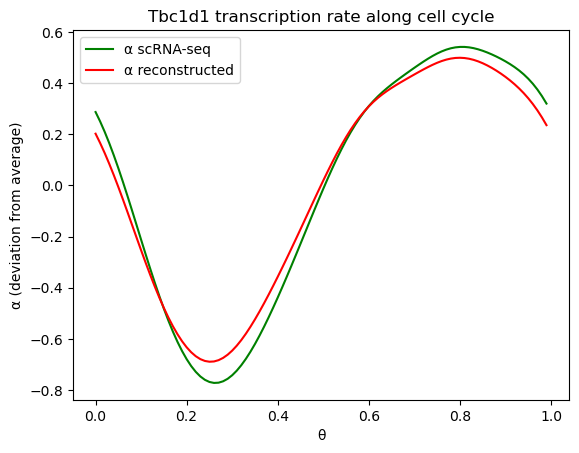

In [ ]:
#Compare actual rates with reconstructed
plot_rate_comparison(genenames_filtered, alpha, R, process, theta, target_nb= 9)

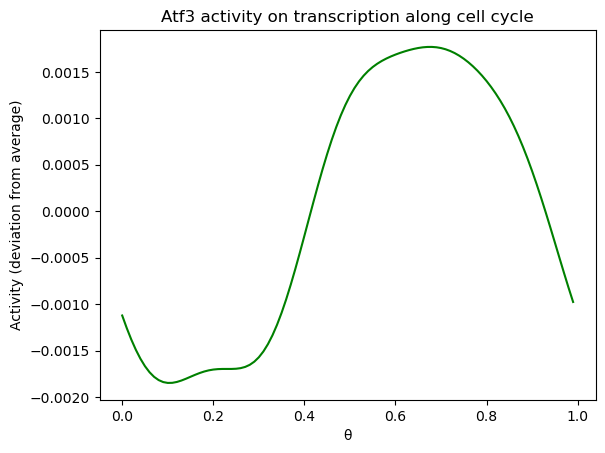

In [ ]:
#Activity of the transcription factor
plot_binding_protein_activity(tf_names, A, BP_nb = 10)

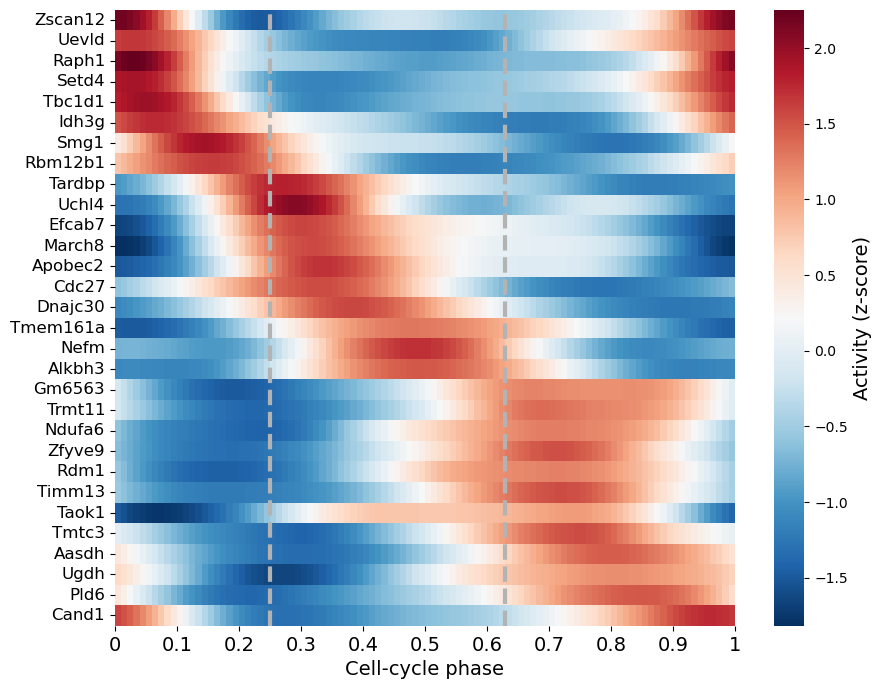

In [ ]:
#Heatmap of targets activity (expression, splicing, export, degradation) along cell cycle
plot_heatmap(alpha, ylabels=genenames_filtered, display_limit=30)

In [ ]:
#We keep only the BPs that regulates retained targets.
total_binding_sites = N.sum(axis=0) #Each column (=BP) now contains the total number of binding sites across all targets (sum along the rows)
A = A[total_binding_sites > 0, :]
tf_names = tf_names[total_binding_sites > 0]
#Number of active motif that regulates retained targets
print("Kept TFs :", np.sum(total_binding_sites > 0))

Kept TFs : 153


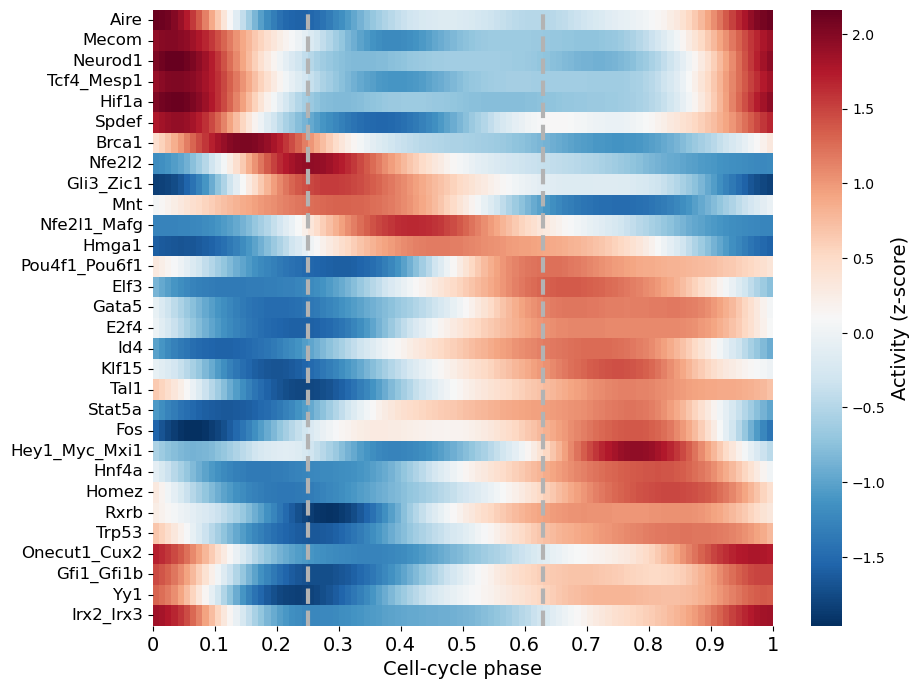

In [ ]:
#Heatmap of BPs activity along cell cycle
plot_heatmap(A, ylabels=tf_names, display_limit=30)

In [ ]:
%%!

UsageError: %%! is a cell magic, but the cell body is empty.


### Splicing

### Export

In [ ]:
#Import files containing the binding sites and the process rates for each target.
fileBSM = 'FurierCycleResults/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileEta = 'FurierCycleResults/bootstrap_eta_snrna_rep1_100_1_1.csv'
#Defining the process (name, greek letter)
process = ["export", "\u03B7"]

In [ ]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)
N = N.drop(N.columns[-1], axis=1)
eta = pd.read_csv(fileEta, sep=",",index_col=0)
theta = np.arange(0, 1, 0.01)

In [ ]:
# PREPROCESSING
# Select targets for which we know binding sites for BPs
RBP_names = N.columns
print("Initial RNAs :", eta.shape[0])
eta, N, RNAnames_filtered = preprocessing(N, eta, threshold=2)

#Number of retained RNAs
print("Kept RNAs :", eta.shape[0])

Initial RNAs : 115820
Kept RNAs : 491


In [ ]:
# SOLVING THE LINEAR MODEL (X the activities in FS, A in NS)
X, A = fourier_resolution(N, eta, num_harmonics=5)

# Reconstructed rates = N*A
R = N @ A

# Explained variance
EV = 1-np.var(R.flatten()-eta.flatten())/np.var(eta.flatten())
#Correlation coefficient
c = np.corrcoef(eta.flatten(),R.flatten())[0,1]
print(EV,c)

0.20413428384258392 0.45252307148127413


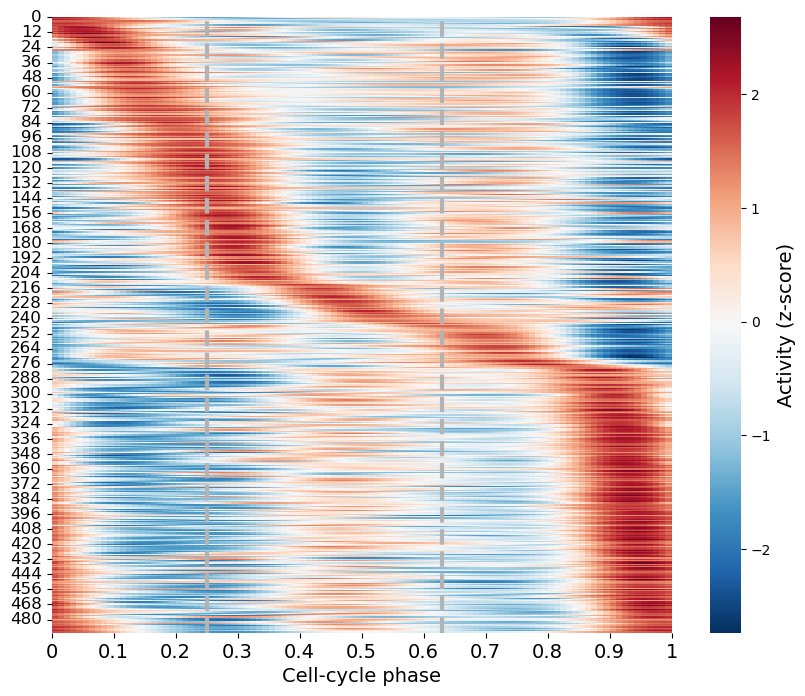

In [ ]:
#Heatmap of targets activity (expression, splicing, export, degradation) along cell cycle
plot_heatmap(eta, ylabels=None, display_limit=None)

In [ ]:
#We keep only the BPs that regulates retained targets.
total_binding_sites = N.sum(axis=0) #Each column (=BP) now contains the total number of binding sites across all targets (sum along the rows)
A = A[total_binding_sites > 0, :]
print("Initial RBPs :", RBP_names.shape[0])
RBP_names = RBP_names[total_binding_sites > 0]
#Number of active motif that regulates retained targets
print("Kept RBPs :", np.sum(total_binding_sites > 0))

Initial RBPs : 95
Kept RBPs : 51


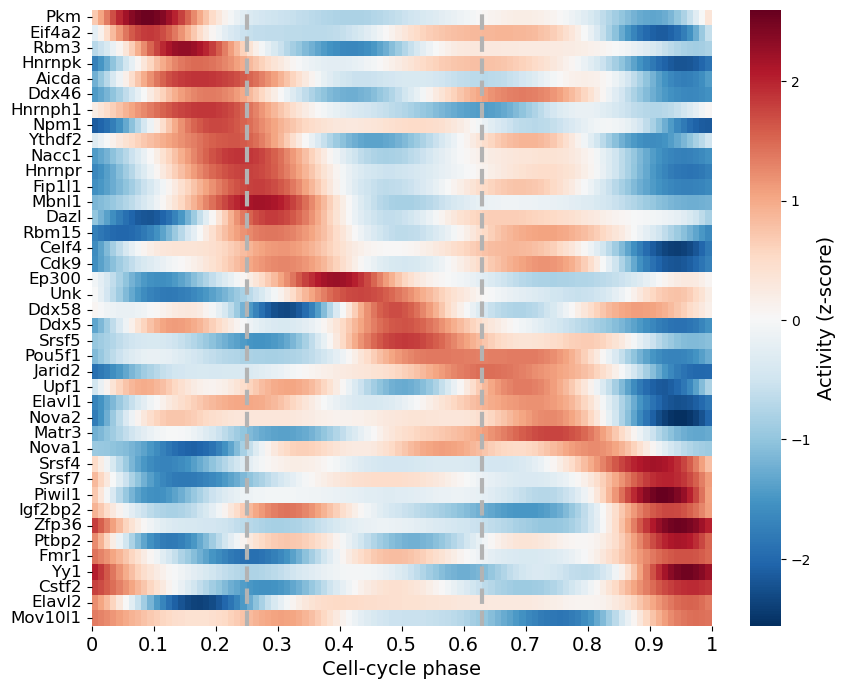

In [ ]:
#Heatmap of BPs activity along cell cycle
plot_heatmap(A, ylabels=RBP_names, display_limit=40)

### Degradation

In [ ]:
#Import files containing the binding sites and the process rates for each target.
fileBSM = 'FurierCycleResults/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileGamma = 'FurierCycleResults/bootstrap_gamma_scrna_100_1_1.csv'
#Defining the process (name, greek letter)
process = ["degradation", "\u03B3"]

In [ ]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)
N = N.drop(N.columns[-1], axis=1)
gamma = pd.read_csv(fileGamma, sep=",",index_col=0)
theta = np.arange(0, 1, 0.01)

In [ ]:
# PREPROCESSING
# Select targets for which we know binding sites for BPs
RBP_names = N.columns
print("Initial RNAs :", gamma.shape[0])
gamma, N, RNAnames_filtered = preprocessing(N, gamma, threshold=1.5)

#Number of retained RNAs
print("Kept RNAs :", gamma.shape[0])

Initial RNAs : 122380
Kept RNAs : 336


In [ ]:
# SOLVING THE LINEAR MODEL (X the activities in FS, A in NS)
X, A = fourier_resolution(N, gamma, num_harmonics=5)

# Reconstructed rates = N*A
R = N @ A

# Explained variance
EV = 1-np.var(R.flatten()-gamma.flatten())/np.var(gamma.flatten())
#Correlation coefficient
c = np.corrcoef(gamma.flatten(),R.flatten())[0,1]
print(EV,c)

0.2746541585255844 0.5254622490067528


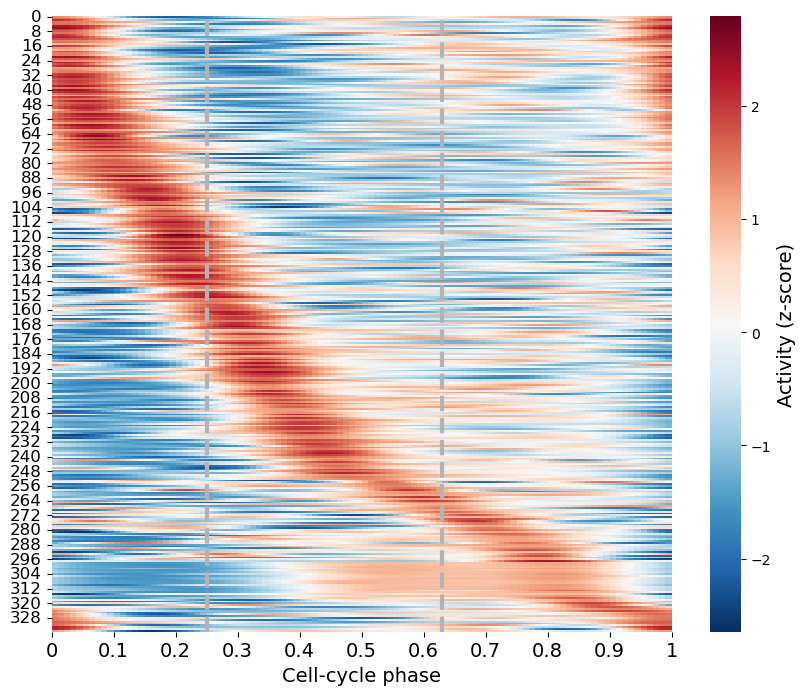

In [ ]:
#Heatmap of targets activity (expression, splicing, export, degradation) along cell cycle
plot_heatmap(gamma, ylabels=None, display_limit=None)

In [ ]:
#We keep only the BPs that regulates retained targets.
total_binding_sites = N.sum(axis=0) #Each column (=BP) now contains the total number of binding sites across all targets (sum along the rows)
A = A[total_binding_sites > 0, :]
print("Initial RBPs :", RBP_names.shape[0])
RBP_names = RBP_names[total_binding_sites > 0]
#Number of active motif that regulates retained targets
print("Kept RBPs :", np.sum(total_binding_sites > 0))

Initial RBPs : 95
Kept RBPs : 55


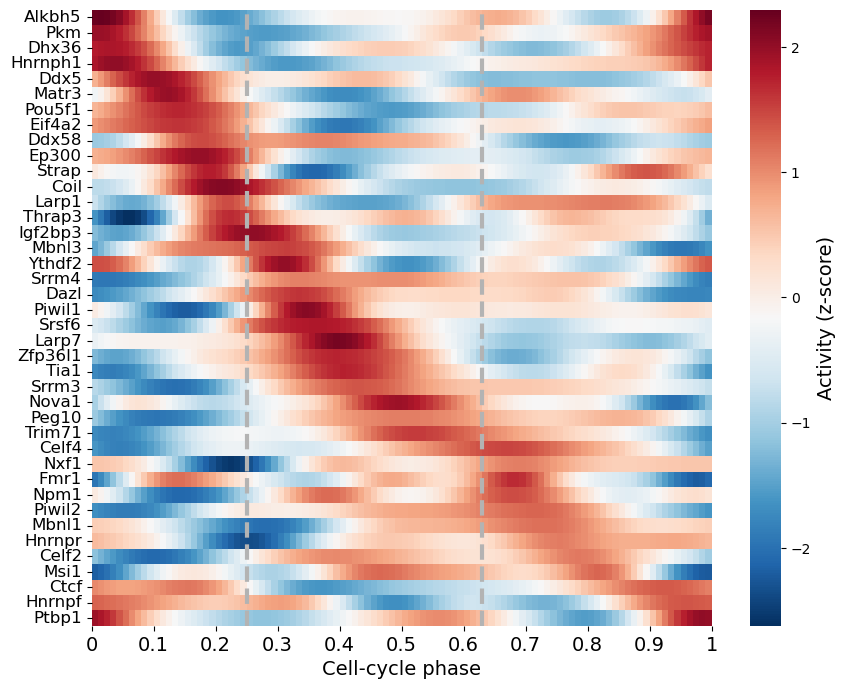

In [ ]:
#Heatmap of BPs activity along cell cycle
plot_heatmap(A, ylabels=RBP_names, display_limit=40)